# Sentences sentimental comparision using Recurrent Neural Network

__Date:__ 04/15/2020
<br>__Project description:__ building a simple neural network to analyze and compare the sentimental of two sentences (in English). The network takes two sentences as input and determine if two sentences are contradicting, entailing or neutral.
<br>Data example:
<ul>
    <li>Sentence 1: A land rover is being driven across a river</li>
    <li>Sentence 2: A sedan is stuck in the middle of a river</li>
    <li>Label: Contradiction</li>
</ul>

<br>__Methodology:__ Data processing, Deep learning, natural language processing, recurrent neural network.
<br>__Tools:__ pandas, numpy, Keras.
<br>__Dataset:__ Standford Natural Language Inferece (SNLI) Corpus.
<br>__Dataset copyright:__ http://nlp.stanford.edu/pubs/snli_paper.pdf

	Samuel R. Bowman, Gabor Angeli, Christopher Potts, and Christopher D. Manning. 2015.
	A large annotated corpus for learning natural language inference. 
	Proceedings of the 2015 Conference on Empirical Methods in Natural Language Processing (EMNLP)
    
<br>__Word Embedding copyright:__
    Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation.

### 1. Importing libraries

In [91]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import text_to_word_sequence
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout, Flatten, GlobalAveragePooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences

### 2. Data set overview

In [3]:
dataset = pd.read_csv('datasets/snli_1.0_train.csv') #Loading train data set
dataset.head()

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
0,neutral,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( is ( ( training ( his horse...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,3416050480.jpg#4,3416050480.jpg#4r1n,neutral,NaN,NaN,NaN,NaN
1,contradiction,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( ( ( is ( at ( a diner ) ) )...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",3416050480.jpg#4,3416050480.jpg#4r1c,contradiction,NaN,NaN,NaN,NaN
2,entailment,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,"( ( A person ) ( ( ( ( is outdoors ) , ) ( on ...",(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",3416050480.jpg#4,3416050480.jpg#4r1e,entailment,NaN,NaN,NaN,NaN
3,neutral,( Children ( ( ( smiling and ) waving ) ( at c...,( They ( are ( smiling ( at ( their parents ) ...,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VB...,Children smiling and waving at camera,They are smiling at their parents,2267923837.jpg#2,2267923837.jpg#2r1n,neutral,NaN,NaN,NaN,NaN
4,entailment,( Children ( ( ( smiling and ) waving ) ( at c...,( There ( ( are children ) present ) ),(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NN...,Children smiling and waving at camera,There are children present,2267923837.jpg#2,2267923837.jpg#2r1e,entailment,NaN,NaN,NaN,NaN


There are many columns in this dataset, but for the scope of this project, only the following columns will be used:
<ul>
    <li>Gold_Label</li>
    <li>Sentence1</li>
    <li>Sentence2</li>
</ul>

In [4]:
dataset_dropped = dataset.drop(axis=1,columns=['sentence1_binary_parse','sentence2_binary_parse','sentence1_parse','sentence2_parse','label1','label2','label3','label4','label5','captionID','pairID'])   #Dropping unused columns
dataset_dropped.head(3)

,gold_label,sentence1,sentence2
0,neutral,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.
1,contradiction,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette."
2,entailment,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse."


Checking for NaN (null) values in data set (There are 6 in this data set)

In [5]:
dataset_dropped.isnull().sum().sum()

6

In [6]:
dataset_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550152 entries, 0 to 550151
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   gold_label  550152 non-null  object
 1   sentence1   550152 non-null  object
 2   sentence2   550146 non-null  object
dtypes: object(3)
memory usage: 12.6+ MB


There are 6 rows that have null (Not a value aka NaN) in "Sentence2" column. These rows will need to be cleaned later in the data processing step

In [7]:
dataset_dropped.describe()

,gold_label,sentence1,sentence2
count,550152,550152,550146
unique,4,150736,480040
top,entailment,A dog in a field.,A man is sleeping.
freq,183416,33,335


There are 4 unique labels in the dataset, which is not standard. There is supposed only 3 unique values: contradiction, neutral, and entailment. Lets see what is the 4th value.

In [8]:
dataset_dropped[~dataset_dropped['gold_label'].isin(['contradiction', 'neutral','entailment'])]

,gold_label,sentence1,sentence2
145,-,A small group of church-goers watch a choir pr...,A choir performs in front of packed crowd.
783,-,A woman wearing a pink hat is looking at a pin...,The woman is wearing clothes.
1562,-,man in red canada shirt standing with three me...,Man standing with three men in army uniform ne...
2593,-,A man in a white jacket standing in front of a...,The man was playing crochet with the two women.
2881,-,A swimmer's hand is taken as he gets out of th...,The swimmer is female.
...,...,...,...
548159,-,Four people are selecting foods from the buffet.,The people are looking at the things being ser...
548466,-,An outdoor market vendor reaches up with a pol...,A woman prepares for her day of business by ge...
548920,-,One black dog chases another on grass nearby a...,There is grass on a road eventhough it snowed ...
549427,-,The couple pauses atop a rocky overlook.,The couple is walking on a rockky overlook.


There are 785 rows that doesnt have a standard gold label. These rows will be removed later in the data processing step.

### 3. Creating data preprocessing and support functions

In [11]:
def raw_to_X_Y_words(path):
    ''' Input:
            path: data set file location
        Output:
            X_words: a numpy array contains pairs of sentences. Each pair is list of words from two sentences.
            Y_words: a numpy array contains labels
    '''
    
    orig = pd.read_csv(path)
    dropped = orig.drop(axis=1,columns=['sentence1_binary_parse','sentence2_binary_parse','sentence1_parse','sentence2_parse','label1','label2','label3','label4','label5',])   #Dropping unused columns
    dropped = dropped.loc[dropped['gold_label'] != '-']   #Dropping rows without a label
    dropped.dropna(inplace = True)   #Dropping row that is rull
    sentences = (dropped['sentence1'] + dropped['sentence2']).to_list() #Concatenate a pair of sentences into a single sentences
    X_words = []
    for pair in sentences:
        if isinstance(pair, float): #Ignoring rows that has incorrect format (in this case sometimes a row is not a string, but a float)
            continue
        sequence = text_to_word_sequence(pair) #Convert two-sentences-pair string into a list of words. 
        X_words.append(sequence)
    X_words = np.asarray(X_words)
    Y_words = dropped['gold_label'].to_list()
    Y_words = np.asarray(Y_words)
    return X_words, Y_words

In [62]:
def words_to_encoded_sequences(X, Y, word_to_index):
    ''' Input:
            X: a numpy array contains pairs of sentences. Each pair is list of words from two sentences.
            Y: a numpy array contains labels.
            word_to_index: a dictionary that maps each word to its correspoding index number.
        Output:
            X_encoded: a numpy array contains pairs of sentences. Each pair is list of indexes of words from two sentences.
            Y_encoded: a numpy array contains labels. Each label is a list of one-hot-encoded label.
    '''
    X_encoded = []
    for pair in X:
        current_sentence_encode = []
        for word in pair:
            if word in word_to_index:
                current_sentence_encode.append(word_to_index[word]) 
            else:
                current_sentence_encode.append(word_to_index['UNK'])
        X_encoded.append(current_sentence_encode)
    Y_encoded = []
    for word in Y:
        temp = []
        if word == 'neutral':
            temp = [0,1,0]
        if word == 'contradiction':
            temp = [1,0,0]
        if word==  'entailment':
            temp = [0,0,1]
        Y_encoded.append(temp)
    X_encoded = np.asarray(X_encoded)
    Y_encoded = np.asarray(Y_encoded)
    return X_encoded, Y_encoded

In [13]:
def text_to_encoding_list(sentence):
    sequence = text_to_word_sequence(sentence) #Convert input string into a sequence of words
    encoding_list = []
    for word in sequence:
        if word in word_to_index:
            encoding_list.append(word_to_index[word]) #For each words, append its corresponding index in encoding_list
        else:
            encoding_list.append(word_to_index['UNK']) #Append unknown (0) if word is not in vocabulary
    return encoding_list

In [14]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0) 

### 4. Preprocessing data

___4a. Loading dataset___

In [53]:
X_train_words, Y_train_words = raw_to_X_Y_words('datasets/snli_1.0_train.csv')
X_dev_words, Y_dev_words = raw_to_X_Y_words('datasets/snli_1.0_dev.csv')
X_test_words, Y_test_words = raw_to_X_Y_words('datasets/snli_1.0_test.csv')

<BarContainer object of 3 artists>

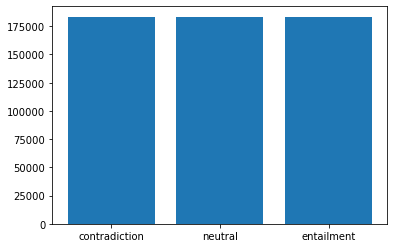

In [178]:
labels_count_dict = {'contradiction':np.count_nonzero(Y_train_words=='contradiction'),
                'neutral':np.count_nonzero(Y_train_words=='neutral'),
                'entailment':np.count_nonzero(Y_train_words=='entailment'),
               }
labels = list(labels_count_dict.keys())
labels_count = list(labels_count_dict.values())
plt.bar(labels,labels_count)

The labels distribution are very balanced

___4b. Creating word-to-index mapping dictionary___

In [54]:
word_to_index = {'UNK':0}
vocab_len = 1
for pair in X_train_words:
    for word in pair:
        if word in word_to_index:
            continue
        else:
            word_to_index[word] = vocab_len
            vocab_len += 1
print('Size of vocabulary: '+ str(len(word_to_index)))

Size of vocabulary: 40437


___4c. Formating datasets___

In [63]:
#Convert data from sequence-of-words to sequence-of-encodings
X_train, Y_train = words_to_encoded_sequences(X_train_words, Y_train_words, word_to_index)
X_dev, Y_dev = words_to_encoded_sequences(X_dev_words, Y_dev_words, word_to_index)
X_test, Y_test = words_to_encoded_sequences(X_test_words, Y_test_words, word_to_index)
print('X train record count:' + str(len(X_train)))
print('Y train record count:' + str(len(Y_train)))
print('X dev record count:' + str(len(X_dev)))
print('Y dev record count:' + str(len(Y_dev)))
print('X test record count:' + str(len(X_test)))
print('Y test record count:' + str(len(Y_test)))

X train record count:549361
Y train record count:549361
X dev record count:9842
Y dev record count:9842
X test record count:9824
Y test record count:9824


In [71]:
#Finding the max length of sentence in training dataset
max_sentence_len = 0
for pair in X_train:
    if len(pair) > max_sentence_len:
        max_sentence_len = len(pair)


In [72]:
#Pad all sentences with 0, as to make all sentences to have the same length.
X_train = pad_sequences(X_train, maxlen = max_sentence_len)
X_dev = pad_sequences(X_dev, maxlen = max_sentence_len)
X_test = pad_sequences(X_test, maxlen = max_sentence_len)

### 5. Building recurrent neural network

<b>Note:</b>The variables (embedding depth, learning rate) and the structure of the neural network have been tunded to maximize performance, with the best knowledge and resources available at the time of implementation. The tuning process was time consuming and is not included in here.

In [145]:
embedd_depth = 20
lr = 0.05

In [147]:
sgd = tf.compat.v1.train.MomentumOptimizer(learning_rate = lr, momentum=0.9, use_nesterov=True)
model = Sequential()
model.add(Embedding(vocab_len, embedd_depth, input_length = max_sentence_len))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=sgd , metrics=['accuracy'])
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 112, 20)           808740    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 112, 64)           13568     
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 64)                24832     
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 195       
Total params: 847,335
Trainable params: 847,335
Non-trainable params: 0
_________________________________________________________________
None


### 6. Training

In [148]:
history = model.fit(X_train, Y_train, validation_data=(X_dev, Y_dev), epochs=30, batch_size=2028)

Train on 549361 samples, validate on 9842 samples
Epoch 1/30
549361/549361 [==============================] - 180s 329us/step - loss: 1.0961 - accuracy: 0.3584 - val_loss: 1.0883 - val_accuracy: 0.3804
Epoch 2/30
549361/549361 [==============================] - 175s 318us/step - loss: 1.0470 - accuracy: 0.4406 - val_loss: 1.0097 - val_accuracy: 0.4697
Epoch 3/30
549361/549361 [==============================] - 175s 319us/step - loss: 0.9771 - accuracy: 0.5148 - val_loss: 0.9506 - val_accuracy: 0.5416
Epoch 4/30
549361/549361 [==============================] - 175s 318us/step - loss: 0.9192 - accuracy: 0.5656 - val_loss: 0.8662 - val_accuracy: 0.6077
Epoch 5/30
549361/549361 [==============================] - 184s 334us/step - loss: 0.8703 - accuracy: 0.6007 - val_loss: 0.8398 - val_accuracy: 0.6231
Epoch 6/30
549361/549361 [==============================] - 175s 319us/step - loss: 0.8452 - accuracy: 0.6165 - val_loss: 0.8214 - val_accuracy: 0.6295
Epoch 7/30
549361/549361 [============

Visualizing training accuracy and loss

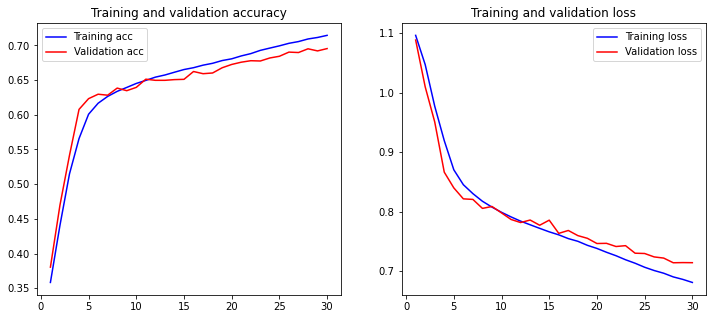

In [149]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

Using a pretrained Embedding from Glove to increase model accuracy

In [158]:
embedding_index={}
embedd_depth = 100
with open('glove.6B.100d.txt', encoding='utf8') as file:
    for line in file:
        values = line.split();
        word = values[0];
        coefs = np.array(values[1:], dtype='float32')
        embedding_index[word]=coefs

embedding_matrix=np.zeros((vocab_len, embedd_depth))
for word, i in word_to_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [180]:
pre_trained_model = Sequential()
pre_trained_model.add(Embedding(vocab_len, embedd_depth, input_length = max_sentence_len, weights=[embedding_matrix],trainable=False))
pre_trained_model.add(Bidirectional(LSTM(32, return_sequences=True)))
pre_trained_model.add(Bidirectional(LSTM(32)))
pre_trained_model.add(Dropout(0.2))
pre_trained_model.add(Dense(3, activation='softmax'))
pre_trained_model.compile(loss='categorical_crossentropy', optimizer='adam' , metrics=['accuracy'])
print(pre_trained_model.summary())

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 112, 100)          4043700   
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 112, 64)           34048     
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 64)                24832     
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 195       
Total params: 4,102,775
Trainable params: 59,075
Non-trainable params: 4,043,700
_________________________________________________________________
None


In [181]:
history1 = pre_trained_model.fit(X_train, Y_train, validation_data=(X_dev, Y_dev), epochs=30, batch_size=2028)

Train on 549361 samples, validate on 9842 samples
Epoch 1/30
549361/549361 [==============================] - 186s 338us/step - loss: 0.9573 - accuracy: 0.5329 - val_loss: 0.8803 - val_accuracy: 0.5953
Epoch 2/30
549361/549361 [==============================] - 178s 325us/step - loss: 0.8581 - accuracy: 0.6072 - val_loss: 0.8211 - val_accuracy: 0.6308
Epoch 3/30
549361/549361 [==============================] - 177s 321us/step - loss: 0.8146 - accuracy: 0.6345 - val_loss: 0.7894 - val_accuracy: 0.6509
Epoch 4/30
549361/549361 [==============================] - 177s 322us/step - loss: 0.7873 - accuracy: 0.6514 - val_loss: 0.7663 - val_accuracy: 0.6610
Epoch 5/30
549361/549361 [==============================] - 179s 326us/step - loss: 0.7677 - accuracy: 0.6626 - val_loss: 0.7499 - val_accuracy: 0.6722
Epoch 6/30
549361/549361 [==============================] - 187s 341us/step - loss: 0.7533 - accuracy: 0.6706 - val_loss: 0.7412 - val_accuracy: 0.6774
Epoch 7/30
549361/549361 [============

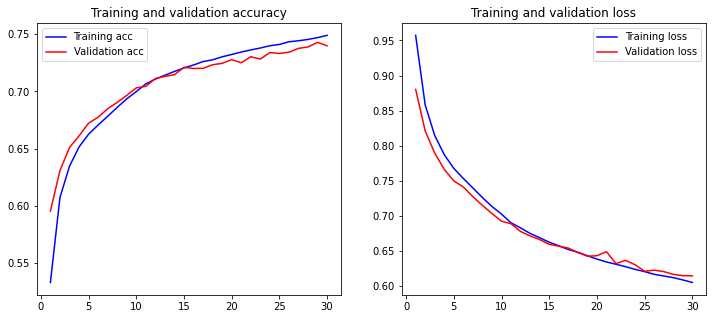

In [182]:
plot_history(history1)

### 7. Model evaluation

In [183]:
#Evaluate the two model using Test data
results1 = model.evaluate(X_test, Y_test, batch_size = 1024)
results2 = pre_trained_model.evaluate(X_test, Y_test, batch_size = 1024)

9824/9824 [==============================] - 3s 258us/step


In [185]:
print('My model accuracy on Test data: ''%.2f' % (results1[1]*100)+ '%')
print('Model with pretrained Embedding accuracy on Test data: ''%.2f' % (results2[1]*100)+ '%')

My model accuracy on Test data: 69.69%
Model with pretrained Embedding accuracy on Test data: 74.12%


With pre-trained Embedding, accuracy on test data improved by 4.43%!

In [194]:
#Input random pairs of sentences to test the model
sentence1 = 'The dog plays in the park'
sentence2 = 'There is a dog in the park'

pair1 = sentence1 + ' ' + sentence2
encoded_pair1 = text_to_encoding_list(pair1)

sentence1 = 'The child plays in the park'
sentence2 = 'The woman crys in her house'
pair2 = sentence1 + ' ' + sentence2
encoded_pair2 = text_to_encoding_list(pair2)

sentence1 = 'Two blond women are hugging one another'
sentence2 = 'Some men are socializing on vacation'
pair3 = sentence1 + ' ' + sentence2
encoded_pair3 = text_to_encoding_list(pair3)


encoded_pair = np.array([encoded_pair1,encoded_pair2,encoded_pair3])
encoded_pairs = pad_sequences(encoded_pair, maxlen = max_sentence_len)
testing = model.predict(encoded_pairs)

In [197]:
label_type =['Contradiction', 'Neutral', 'Entailment']

print("Pair 1 is: ",label_type[np.argmax(testing[0])])
print("Pair 2 is: ",label_type[np.argmax(testing[1])])
print("Pair 3 is: ",label_type[np.argmax(testing[2])])

Pair 1 is:  Entailment
Pair 2 is:  Contradiction
Pair 3 is:  Neutral


### 8. Conclusion
The recurrent neural network was able to achieve <b>74.12%</b> accuracy with a simple structure with an embedding layer, a bidirectional long-short-term-memory layer and a drop-out layer. With more training time (epochs), the model's accuracy can definitely improved.
The purpose of this project, is to help exploring and learning to implement a recurrent neural network with Keras, is fulfilled.